In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf
import math

# Pre processing

In [2]:
path = '/anomalyvol/data/jet_ver/bb3_ae_input_leading2.h5'  # just leading 2 tags for each event

In [3]:
chunk_size = 100000
total_size = 1000000 # 1 mil max

def generator(path, chunk_size=10000,total_size=1000000):
    i = 0
    
    while True:
        yield pd.read_hdf(path,start=i*chunk_size, stop=(i+1)*chunk_size)
        
        i+=1
        if (i+1)*chunk_size > total_size:
            i=0

gen = generator(path, chunk_size, total_size)

In [4]:
data = next(gen)

for i in range(total_size // chunk_size - 1):
    data.append(next(gen))

In [5]:
loaded_data = data
# data = loaded_data

In [6]:
loaded_data

,px,py,pz,e,pt,eta,phi,mass,event
0,-246.611967,-1175.708801,-1883.403633,2243.389820,1201.294571,-1.231799,-1.777555,206.106750,0
1,225.046695,1100.375754,-28.057311,1198.183978,1123.153068,-0.024978,1.369060,416.395028,0
2,-1334.635429,-70.470841,-236.450266,1359.133310,1336.494619,-0.176008,-3.088840,71.531523,1
3,1078.256600,-8.640365,53.734438,1106.628835,1078.291218,0.049812,-0.008013,242.956863,1
4,-1181.287513,408.154270,-844.470992,1522.847041,1249.812024,-0.632628,2.808918,209.527459,2
...,...,...,...,...,...,...,...,...,...
99995,533.376849,1045.464759,-649.226314,1384.321422,1173.664103,-0.528249,1.099037,342.583665,49997
99996,1668.842257,-59.777430,1061.132453,1992.237394,1669.912519,0.598978,-0.035804,233.237928,49998
99997,-1292.798663,-590.225210,922.351953,1699.146599,1421.159450,0.610397,-2.713306,129.119548,49998
99998,-1141.014921,-550.535492,1393.159459,1889.935699,1266.887674,0.950126,-2.692046,161.118872,49999


In [7]:
data = np.array(data)
data = data[:,:4]  # just keep px, py, pz, e
data.shape

(100000, 4)

In [8]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [9]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [10]:
# get the inverse iqr proportion for each feature used to scale their weights in the loss function
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.9978627  1.         0.67718086 0.58845679]


# VAE Model

In [11]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [12]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [14]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [15]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [16]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [17]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

def earth_mover_loss(y_true, y_pred): # source: https://github.com/titu1994/neural-image-assessment/blob/master/train_mobilenet.py#L49
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)

vae.compile(optimizer='adam', loss=ae_loss)

In [18]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
batch_size = 1000
epochs = 200

In [21]:
x_train.shape

(80000, 4)

In [22]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [23]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 80000 samples, validate on 10000 samples
Epoch 1/200
80000/80000 [==============================] - 2s 23us/step - loss: 0.6413 - val_loss: 0.4724
Epoch 2/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.3582 - val_loss: 0.2976
Epoch 3/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.2630 - val_loss: 0.2351
Epoch 4/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.2071 - val_loss: 0.1869
Epoch 5/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.1705 - val_loss: 0.1573
Epoch 6/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.1473 - val_loss: 0.1381
Epoch 7/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.1305 - val_loss: 0.1233
Epoch 8/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.1177 - val_loss: 0.1144
Epoch 9/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.1094 - val_loss: 0.1071
Epoc

Epoch 78/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0368 - val_loss: 0.0380
Epoch 79/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0368 - val_loss: 0.0400
Epoch 80/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0364 - val_loss: 0.0355
Epoch 81/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0361 - val_loss: 0.0379
Epoch 82/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0356 - val_loss: 0.0357
Epoch 83/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0356 - val_loss: 0.0353
Epoch 84/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0358 - val_loss: 0.0358
Epoch 85/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0360 - val_loss: 0.0359
Epoch 86/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0352 - val_loss: 0.0357
Epoch 87/200
80000/80000 [====================

# Visualization

In [24]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


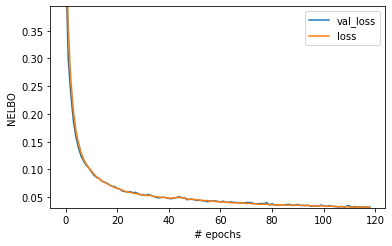

In [25]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [26]:
predictions = vae.predict(x_test)

In [27]:
# mse on test set
p = vae.predict(x_train)
print(mse(p, x_train))

tf.Tensor(0.037844658, shape=(), dtype=float32)


In [28]:
distr = (x_test - predictions) / x_test

In [29]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [30]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for px, py, pz, E

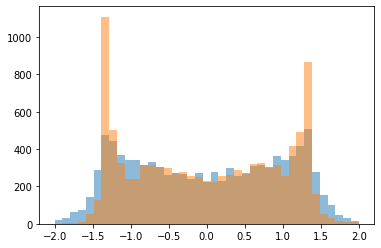

In [31]:
# px
bins = np.linspace(-2, 2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)
plt.show()

In [32]:
print(mse(px,px_pred))

tf.Tensor(0.034797665, shape=(), dtype=float32)


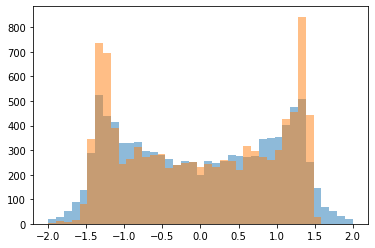

In [33]:
# py
bins = np.linspace(-2, 2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)
plt.show()

In [34]:
print(mse(py,py_pred))

tf.Tensor(0.03677187, shape=(), dtype=float32)


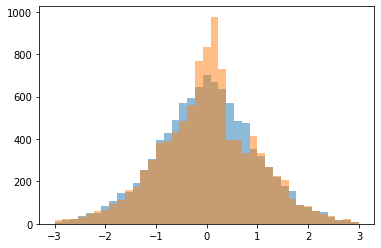

In [35]:
# pz
bins = np.linspace(-3, 3, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)
plt.show()

In [36]:
print(mse(pz,pz_pred))

tf.Tensor(0.043664265, shape=(), dtype=float32)


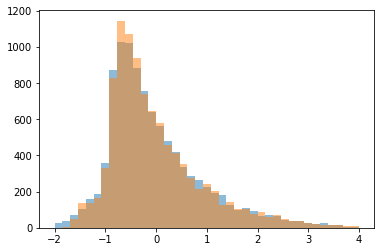

In [37]:
# E
bins = np.linspace(-2,4, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)
plt.show()

In [38]:
print(mse(e,e_pred))

tf.Tensor(0.036322676, shape=(), dtype=float32)


In [39]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [40]:
bins = np.linspace(-2, 2, 30)

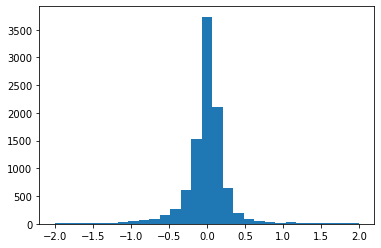

In [41]:
_ = plt.hist(d_px, bins=bins)

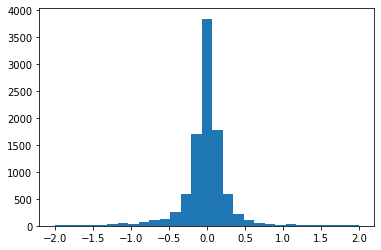

In [42]:
_ = plt.hist(d_py, bins=bins)

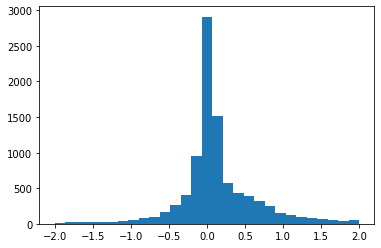

In [43]:
_ = plt.hist(d_pz, bins=bins)

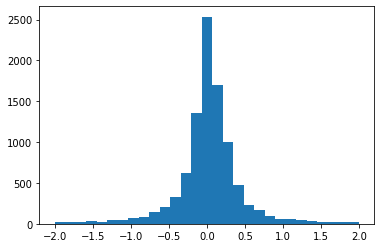

In [44]:
_ = plt.hist(d_e, bins=bins)

# Anomaly Detection

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
# m_12 = sqrt ( (E_1 + E_2)^2 - (p_x1 + p_x2)^2 - (p_y1 + p_y2)^2 - (p_z1 + p_z2)^2 )
def invariant_mass(jet1, jet2):
    return math.sqrt((jet1.e + jet2.e)**2 - (jet1.px + jet2.px)**2 - (jet1.py + jet2.py)**2 - (jet1.pz + jet2.pz)**2)

In [ ]:
def emd_calc(jet1, jet2):
    # https://en.wikipedia.org/wiki/Earth_mover%27s_distance

In [47]:
all_data = np.concatenate((x_train, x_val, x_test))
all_pred = vae.predict(all_data)

In [48]:
# get the iqr weighted mse of all predictions
errors = (iqr_prop[0] * np.square(all_data[:,0] - all_pred[:,0]) + iqr_prop[1] * np.square(all_data[:,1] - all_pred[:,1]) + iqr_prop[2] * np.square(all_data[:,2] - all_pred[:,2]) + iqr_prop[3] * np.square(all_data[:,3] - all_pred[:,3]))

In [49]:
# all the inputs that had high mse
data_df = loaded_data.copy()
data_df.columns = ['px','py','pz','e','pt','eta','phi','mass','event']
data_df["mse"] = errors

In [50]:
mass_mu = data_df.mass.mean()
mass_sd = data_df.mass.std()

In [51]:
cut = 0.95
data_df["outlier"] = 0

# define the outliers by a cut on mse error
mse_thresh = np.quantile(errors, cut)
data_df.loc[data_df["mse"] > mse_thresh, "outlier"] = 1
outliers = data_df.loc[data_df.outlier == 1]

In [52]:
# get the leading 2 jets from the original dataset if at least 1 was classified an outlier
outlier_events = outliers.event.unique()
outliers2 = loaded_data.loc[loaded_data.event.isin(outlier_events)]

In [53]:
# extract the mass of the outliers
mass = []

for event, group in outliers2.groupby(['event']):
    pseudojets_input = np.zeros(len(group), dtype=DTYPE_PTEPM)

    for i in range(len(group.pt.array)):
        pseudojets_input[i]['pT'] = group.pt.array[i]
        pseudojets_input[i]['eta'] = group.eta.array[i]
        pseudojets_input[i]['phi'] = group.phi.array[i]

    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()

    if(len(jets) >= 2):  # just take the invariant mass of the leading 2 jets
        mass.append(invariant_mass(jets[0],jets[1]))

In [54]:
# load in the precalculated invariant mass of all leading 2 jets for all events
path = '/anomalyvol/data/jet_ver/bb3_jet_mass.h5'
mgen = generator(path, chunk_size, total_size)
all_mass = next(mgen)

for i in range(total_size // chunk_size - 1):
    all_mass.append(next(mgen))

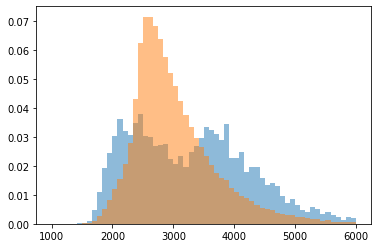

In [55]:
# plot invariant mass (orange = all, blue = outliers)
weights = np.ones_like(mass) / len(mass)
plt.hist(mass, bins=np.linspace(1000,6000, 61), alpha = 0.5, weights=weights)
weights = np.ones_like(all_mass) / len(all_mass)
plt.hist(all_mass.mass, bins=np.linspace(1000,6000, 61), alpha = 0.5, weights=weights)
plt.show()